In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
# File path for carbon intensity dataset
PATH = "C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/processed/df_carbon.parquet"

# Keeps the DATETIME column as an index
df_carbon = pd.read_parquet(PATH)

# Sort Ascending order by index (DATETIME)
df_carbon = df_carbon.sort_index()

# Keep records within the modern period due to less fluctuation in data readings (determined in Notebook 02)
df_carbon = df_carbon[df_carbon.index >= "2020-01-01"]

+ Time features
+ Lag features of CARBON_INTENSITY
+ Lag-1 of key mix features (to avoid leakage)

# Time features

In [3]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek  # 0=Mon
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["month"] = df.index.month
    return df

# Lag Features

In [4]:
def add_lag_features(df: pd.DataFrame, lags=(1, 24, 168)) -> pd.DataFrame:
    df = df.copy()
    for lag in lags:
        df[f"ci_lag_{lag}"] = df["CARBON_INTENSITY"].shift(lag)
    # 24h rolling mean to smooth noise
    df["ci_rollmean_24"] = df["CARBON_INTENSITY"].rolling(24).mean()
    return df

# Lagged mix features (1-hour lag)

In [5]:
MIX_COLS = [
    "FOSSIL", "COAL", "GAS", "NUCLEAR", "STORAGE",
    "GENERATION", "WIND", "HYDRO", "SOLAR", "BIOMASS",
    "RENEWABLE", "OTHER",
]

def add_mix_lag1(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in MIX_COLS:
        df[f"{col}_lag1"] = df[col].shift(1)
    return df

In [6]:
# Building the full Dataframe
df_feat = df_carbon.copy()
df_feat = add_time_features(df_feat)
df_feat = add_lag_features(df_feat, lags=(1, 24, 168))
df_feat = add_mix_lag1(df_feat)

In [7]:
# define target and drop rows with NaNs created by shifting/rolling
TARGET_COL = "CARBON_INTENSITY"

# Drop rows with any NaNs (early lags/rolling)
df_model = df_feat.dropna().copy()

y = df_model[TARGET_COL]

# Exclude original carbon intensity and any raw mix columns from features,
# keep only engineered features + lagged mix.
feature_cols = [
    col for col in df_model.columns
    if col not in (
        ["CARBON_INTENSITY"] + MIX_COLS + ["LOW_CARBON", "ZERO_CARBON"]
    )
]

X = df_model[feature_cols]

# Train / val / test split

In [8]:
train_mask = (df_model.index.year >= 2020) & (df_model.index.year <= 2023)
val_mask   = (df_model.index.year == 2024)
test_mask  = (df_model.index.year == 2025)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

In [9]:
# Sanity Check - Sizes
X_train.shape, X_val.shape, X_test.shape

((34896, 20), (8784, 20), (7786, 20))

In [10]:
# Shared evaluation helper
def evaluate_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    y_tr_pred = model.predict(X_tr)
    y_v_pred  = model.predict(X_v)
    y_te_pred = model.predict(X_te)

    def metrics(y_true, y_pred):
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return mae, rmse

    mae_tr, rmse_tr = metrics(y_tr, y_tr_pred)
    mae_v,  rmse_v  = metrics(y_v,  y_v_pred)
    mae_te, rmse_te = metrics(y_te, y_te_pred)

    print(f"\n=== {name} ===")
    print(f"Train: MAE={mae_tr:.2f}, RMSE={rmse_tr:.2f}")
    print(f"Val:   MAE={mae_v:.2f}, RMSE={rmse_v:.2f}")
    print(f"Test:  MAE={mae_te:.2f}, RMSE={rmse_te:.2f}")

    return {
        "name": name,
        "mae_tr": mae_tr, "rmse_tr": rmse_tr,
        "mae_v": mae_v,   "rmse_v": rmse_v,
        "mae_te": mae_te, "rmse_te": rmse_te,
    }

# Ridge regression

In [11]:
ridge = Ridge(alpha=1.0, random_state=42)

ridge.fit(X_train, y_train)

ridge_results = evaluate_model(
    "Ridge regression",
    ridge,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
)


=== Ridge regression ===
Train: MAE=8.05, RMSE=10.73
Val:   MAE=8.08, RMSE=10.95
Test:  MAE=8.84, RMSE=11.74


A simple linear model with time features + lags does not capture the non-linear behaviour of the grid.

# HistGradientBoostingRegressor

In [12]:
# This algorithm is faster than traditional gradient boosting for large datasets
gboost = HistGradientBoostingRegressor(
    max_depth=8,          # Maximum depth of the trees (controls complexity)
    learning_rate=0.05,   # Small learning rate for better generalization
    max_iter=300,         # Number of boosting iterations (trees)
    random_state=42       # Set seed for reproducibility
)

# Train the model on the training data
gboost.fit(X_train, y_train)

# Evaluate the model's performance on training, validation and test sets
# Results typically include metrics like RMSE, MAE, R² score
gboost_results = evaluate_model(
    "HistGradientBoostingRegressor",  # Model name for reporting
    gboost,                           # Trained model instance
    X_train, y_train,                 # Training data
    X_val,   y_val,                   # Validation data
    X_test,  y_test,                  # Test data
)


=== HistGradientBoostingRegressor ===
Train: MAE=4.86, RMSE=6.44
Val:   MAE=5.65, RMSE=7.63
Test:  MAE=5.97, RMSE=7.98


# Saving Predictions

In [13]:
pred_train = gboost.predict(X_train)
pred_val   = gboost.predict(X_val)
pred_test  = gboost.predict(X_test)

In [14]:
df_preds = pd.DataFrame({
    "CI_actual": y,        # full series
})

df_preds["CI_pred"] = np.nan

df_preds.loc[y_train.index, "CI_pred"] = pred_train
df_preds.loc[y_val.index,   "CI_pred"] = pred_val
df_preds.loc[y_test.index,  "CI_pred"] = pred_test

In [15]:
import os
os.makedirs("../data/predictions", exist_ok=True)
df_preds.to_parquet("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/predictions/ci_predictions.parquet")
print("DataFrame saved to C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/predictions/ci_predictions.parquet")

DataFrame saved to C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/predictions/ci_predictions.parquet


In [16]:
df_preds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51466 entries, 2020-01-08 00:00:00+00:00 to 2025-11-21 09:00:00+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CI_actual  51466 non-null  float64
 1   CI_pred    51466 non-null  float64
dtypes: float64(2)
memory usage: 3.2 MB


# Feature importance ranking

In [17]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance - this evaluates feature importance by measuring
# how much model performance decreases when a feature is randomly shuffled
perm_importance = permutation_importance(
    gboost,  # The trained model to evaluate
    X_test,  # Using test data for evaluation (could also use X_train)
    y_test,  # Target values for test data (could also use y_train)
    n_repeats=10,  # Number of times to permute each feature (more repeats = more stable results)
    random_state=42  # For reproducibility
)

# Create a pandas Series with the mean importance values for each feature
fi = pd.Series(perm_importance.importances_mean, index=feature_cols)
# Sort features by importance in descending order and display the top 20
fi.sort_values(ascending=False).head(20)

ci_lag_1           1.941800
hour               0.040015
SOLAR_lag1         0.013942
ci_rollmean_24     0.002848
dayofweek          0.000955
GAS_lag1           0.000567
RENEWABLE_lag1     0.000439
OTHER_lag1         0.000365
month              0.000291
STORAGE_lag1       0.000276
WIND_lag1          0.000271
GENERATION_lag1    0.000262
ci_lag_24          0.000142
HYDRO_lag1         0.000097
FOSSIL_lag1        0.000088
ci_lag_168         0.000041
is_weekend         0.000000
COAL_lag1         -0.000001
BIOMASS_lag1      -0.000011
NUCLEAR_lag1      -0.000075
dtype: float64

The modern UK grid is highly autoregressive, especially after 2020.
Carbon intensity is explained mostly by the previous hour and the daily demand curve, along with solar, are adding a predictable midday effect.
Mix-based features add value but do not dominate because the grid is now renewables-driven and less volatile when it comes to fossil output.

# Forecasting Plot — Actual vs Predicted

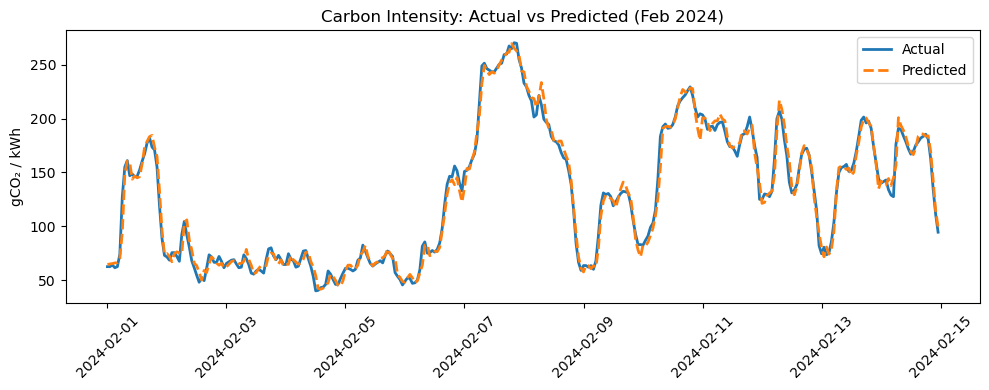

In [24]:
start = "2024-02-01"
end   = "2024-02-14"

subset = df_preds.loc[start:end]

plt.figure(figsize=(10, 4))
plt.plot(subset.index, subset["CI_actual"], label="Actual", linewidth=2)
plt.plot(subset.index, subset["CI_pred"], label="Predicted", linewidth=2, linestyle="--")
plt.ylabel("gCO₂ / kWh")
plt.title("Carbon Intensity: Actual vs Predicted (Feb 2024)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/assets/ci_actual_vs_pred_feb2024.png", dpi=150)
plt.show()